In [2]:
from IPython.display import Image

Reference : 	[arXiv:1806.02473](https://arxiv.org/abs/1806.02473)

화학의 법칙들을 어기지 않으면서, 특정 목표에 대한 분자를 Graph Convolutional Policy Network(GCPN)을 사용해서 만들어내는 것이 이 논문의 주제이다. 중요한 부분은 크게 세 가지가 있다.
1. Graph Representaiton  
    만들어진 graph들의 벡터형 표현을 얻기 위해서 사용되는 방법으로, SMILES와 같은 text형으로 분자를 표현하기 힘든 substructure을 표현하는 것이나 그들의 valency들을 체크하는 것이 가능하다.
2. Adversarial Loss  
    분자를 생성할 때 사전 지식(prior knowledge)을 첨가해주는 역할을 한다. Adversarial training을 하면 Discriminator가 우리가 원하는 성질(정보)들을 내포하면서 Generator가 그 성질들을 가진 분자들을 만들게 하여, 분자를 만들 때 여러 가지 성질들을 한 번에 조절하는 것은 쉽지 않다는 문제를 해결할 수 있다.
3. Reinforcement Learning  
    Drug-discovery 분야에서 중요한 성질인 drug-likeness 혹은 화학적인 valency와 같은 성질들은 목표함수로써 설정하기 힘들다. 이러한 제약조건들을 강화학습을 통하면 학습시킬 수 있고, 데이터셋에 있는 샘플들 말고도 더 새로운 분자들을 만들 수 있다. 모델은 전체적으로 강화학습을 통해 학습된다.

GCPN을 사용하여 분자는 이미 있는 분자의 그래프와 원자 혹은 새로운 substructure를 합하거나, 이미 있는 원자들 사이를 연결하며 만들어진다. GCPN은 bond addition의 action을 예측하고, 이는 목표한 분자의 성질들이나 adversarial loss를 포함한 reward를 optimize시키기 위해 policy gradient 방법으로 학습된다.  
크게 세 가지의 분야에서 실험을 진행하였다: molecule property optimization, property targeting, conditional property optimization.

## Method
이제 모델의 아키텍쳐 부분에 대해 좀 더 알아보자.

### 1. Problem Definition
우선, 그래프 표현을 사용하기 때문에 그래프가 어떤 성분들로 구성되어 있는지 살펴봐야 한다. 논문에서의 그래프 $G$는 $(A, E, F)$라는 세 가지 성분들로 구성되어 있는데, $F$라는 성분은 feature matrix로써, 모든 노드들은 $d$개의 성질을 가지고 있다는 가정 하의 $n \times d$ 크기의 각 노드(원자)의 성질로 구성된 행렬이다. $E$라는 성분은 edge matrix로써, 0이나 1의 값을 가지며 엣지(결합)의 종류가 $b$개일 때, $b \times n \times n$ 크기의 행렬이다. $E_{i,j,k}$는 노드 $j, k$사이의 결합 종류가 $i$일 때 1이 되고, $A$라는 성분은 노드 간의 모든 엣지에 대한 $E$값을 합친 것이다. 즉, $A = \Sigma^b_{i=1} E_i$인 크기 $n \times n$의 adjacency matrix이다.  
Drug discovery 분야의 특성상 만들어야 하는 물질들의 scaffold나 필수적인 성질들이 제한 조건(constrain)으로 작용하고, 그 조건들로부터 원하는 성질을 optimize시켜야 한다. 즉, 만들어진 그래프들은 chemical valency와 같은 빡센 제한 조건들을 모두 만족시켜야 한다. 이러한 사전 지식(prior knowledge)을 지니고 있는 그래프를 만들기 위해, adversarially trained discriminaotr에 샘플 그래프들을 넣고 distance metric $J(\cdot, \cdot)$를 사용한 성질 최적화(property optimization)에 대한 목적함수 $\mathbb E_{G, G'} [J(G, G')]$을 regularize시킨다.

### 2. Graph Generation as Markov Decision Process
우선 Markov Decision Process(MDP)는 [이곳](https://daeson.tistory.com/317)에 [david silver 교수님의 강화학습 강의](https://www.youtube.com/watch?v=lfHX2hHRMVQ&list=PL7-jPKtc4r78-wCZcQn5IqyuWhBZ8fOxT&index=2)를 정리한 것 같은 설명이 잘 나와 있으니 참고하면 좋을 듯 하다.  
그래프를 이용하여 학습을 하는 모델이기 때문에 그래프를 생성하는 방법이 중요하다. 이 과정은 일반적인 decision process인 $M = (S, \mathcal A, P, R, \gamma)$로 표현된다. 하나씩 살펴보면, 우선 $S$는 **state(상태)들**의 집합으로 모든 가능한 중간 과정과 최종적인 그래프들을 포함하고 있고, $\mathcal A$는 **action들의 집합**으로 현재 상태에 오기까지 시간 순서에 따라 취해진 변화를 나타낸다. $R$은 **reward function**으로 특정 state $s_t$에 도달한 후의 reward를 표현하고, $P$는 **trasition dynamics**로써 action을 시행할 때 나올 수 있는 결과물을 가지고 있으며 $p(s_{t+1}|s_t, \dots s_0, a_t)$로 표현된다. 마지막으로, $\gamma$는 미래의 정보를 reward에 얼마나 반영할지를 결정하는 **discount factor**이다.  
Node와 edge를 업데이트할 때 지나온 모든 상태들이 필요한 현재 사용되는 모델들과 달리, Markov Property $p(s_{t+1}|s_t, \dots s_0) = p(s_{t+1}|s_t)$를 만족하기 위해 state transition dynamics가 필요한 MDP를 사용하면 현재 상태에서 취할 action을 얻기 위해 현재 state인 $s_t$에 대한 정보만 필요하고 environment는 그 action으로 중간 과정의 그래프를 업데이트 시킨다.

### 3. Molecule Generation Environment
Environment는 강화 학습에서 agent가 취한 action에 대해 피드백을 받고 policy를 수정할 수 있게 하는 배경이다. 크게 **policy network, state space, action space, state transition dynamics reward design**의 다섯 가지 성분으로 구성된다. 위쪽 부분은 새로운 노드를 더하는 과정을, 아래쪽 부분은 생성 과정을 종료하는 과정을 나타내는 아래의 그림을 통해 설명해보도록 하겠다.

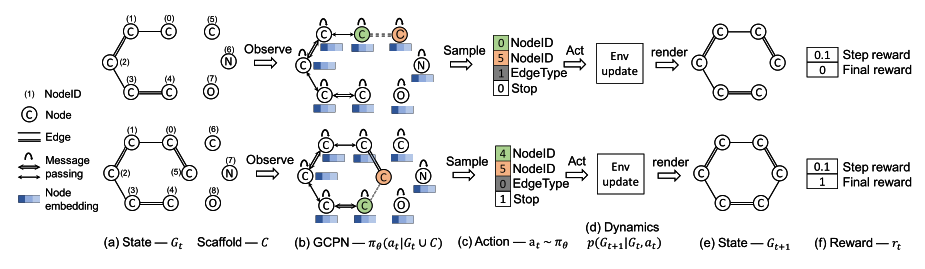

In [3]:
Image(filename = '../img/Graph_Generation.png')

**State Space**는 그래프가 만들어지는 과정을 볼 수 있는 state(상태)에 대한 정보를 포함한다. 그래프 생성이 시작될 때 처음 그래프 $G_0$는 탄소 원자로 구성된 단일 노드를 가지고 있다. 논문에서는 environment의 state $s_t$를 중간 과정의 그래프 $G_t$로 정의하였다. 그림에서 (a)와 (e)는 action이 취해직기 전과 후에 생성된 분자들이다.  
**Action Space**는 action들의 집합으로 link prediction 즉, 다음에 만들어질 결합을 예측하는 것이다. Scaffold subgraphs $C$라는 $\{C_1, \dots, C_s\}$의 scaffold들이 있다. 논문에서는 $C$를 $b$개의 다른 종류의 원자(단일 노드)를 포함한 집합으로 설정하였다. 생성과정에서 $G_t$상태의 그래프와 연결되어 만들어지는 그래프들의 집합을 $G_t \cup C$로 표현한다. Action은 크게 두 가지로 나뉘는데 하나는 $G_t$에 있는 node에 새로운 subgraph $C_i$를 연결하는 것, 다른 하나는 $G_t$에 있는 노드들 사이에 새로운 결합을 만들어내는 것이다. Action이 취해지고 나면, 쓰지 않은 scaffold subgraph들은 모두 제거된다.  
**State Transition Dynamics**는 화학의 기본적인 규칙들을 내재하고 있다. 즉, policy network에 의한 화학의 기본적인 규칙들에 북적합한 action들은 모두 거부되고 state는 바뀌지 않지만, 모든 규칙들을 어기지 않는 action은 충분히 수용되어 업데이트 된다. 그래프를 기반으로한 업데이트가 좋은 점은 중간 과정의 그래프에 대해서도 업데이트를 시키는 과정마다 valency check가 가능하다. 위의 그림에서 (d)를 보면, 두 가지 action들 모두 valency check와 같은 기준을 통과하여 environment가 action에 따라 그래프를 업데이트 시킨다.  
**Reward Design**에서는 두 가지의 보상(reward)에 대해 다룬다. 중간 보상(intermediate reward), 최종 보상(final reward)이 있다. **최종 보상**은 최종적으로 만들어진 분자의 QED, logP, MW와 같은 성질 점수(property score)와 비현실적인 분자일 경우의 penalization을 포함한 domain-specific reward와 adversarial reward의 합이다. **중간 보상**은 업데이트 과정에서 적용되는 보상으로써 과정별 유효성 보상(step-wise validity reward)과 adversarial reward의 합이다. 유효성 보상은 만들어진 중간 과정의 분자가 valency를 위배할 경우 음의 보상, 위배하지 않을 경우 양의 보상을 준다. 위의 그림에서 (f)를 보면, 생성이 종료될 때 최종 보상이 주어지는 것을 볼 수 있다.  
생성되는 분자가 주어진 분자를 닮아 있어야 하기 때문에, 논문에서는 Generative Adversarial Network(GAN)을 사용하여 adversarial reward를 다음과 같이 정의하였다.
$$min_\theta max_\phi V(\pi_\theta, D_\theta) = \mathbb E_{x \sim p_{data}} [logD_\phi(x)] + \mathbb E_{x \sim \pi_\theta}[logD_\phi(1-x)]$$
일반적인 GAN의 loss는 아래의 식과 같다.
$$min_G max_D V(D,G) = \mathbb E_{x \sim p_{data}} [logD(x)] + \mathbb E_{x \sim p_x(x)} [log(1-D(G(z))]$$
Adversarial reward에서 $\pi_\theta$는 policy network, $D_\theta$는 discriminator network를, $x$는 input 그래프, $p_{data}$는 최종 그래프나 중간 그래프들에 의해 정의되는 기본 데이터 분포이다. GAN은 discriminator를 학습시킨 후 optimal한 discriminator가 되었다고 가정하여 고정시킨 상태로 generator를 학습시킨다. GCPN에서는 policy가 분자를 생성하도록 도와주기 때문에 generator 역할을 한다고 보면 된다. 따라서 두 번째 항이 같은 의미를 지녀야 하는데 이는 GCPN의 reward를 나타내는 첫 번째 식에서 오타가 났다고 보면 된다. 원래대로라면 $E_{x \sim \pi_\theta}[log(1-D_\phi(x))]$일 것이다. 식을 보면, 두 가지의 parameter가 있다. $\theta$는 policy $\pi$에 대한, $\phi$는 discriminator에 대한 parameter이고, policy의 결과는 불연속적인(discrete) 그래프 벡터이므로 미분 불가능하여 stochastic gradient descent 방법을 쓸 수가 없다. 따라서 이러한 GAN을 학습시킬 방법으로 reward를 통해 학습시키는 방법을 쓴 것이다. Policy를 업데이트할 때 reward가 높아지는 방향으로 업데이트가 되기 때문에 $-V(\pi_\theta, D_\theta)$를 reward로 다른 reward와 함께 학습시킨다면 reward가 최대화 되기 위해 우리가 첫 번째 식에서 본 것처럼 $V$의 값을 최소로 만들어주는 $\theta$값을 찾을 수 있는 것이다. Discriminator network는 바로 다음 부분에서 설명할 node embedding을 계산하기 위한 policy network와 같은 구조를 가진다.

### 4. Graph Convolutional Policy Network
이제 진짜 강화학습에 의해 학습되어 environment에 적용되는 policy network인 GCPN의 아키텍쳐에 대해 알아볼 시간이다. GCPN은 input으로 중간 과정의 그래프인 $G_t$와 scaffold subgraph 집합 $C$를 받아 output으로 다음에 만들어질 결합을 예측하는 action $a_t$를 만들어낸다. **Computing Node Embeddings**와 **Action Prediction** 두 가지 과정으로 구성된다.  
**Computing Node Embeddings**은 결합을 예측하는 것보다 우선적으로 이루어져야 한다. 결합 종류에 대한 정보를 포함한 Message Passing Neural Network를 사용하였다(GCN을 사용하였다고 하는데 거의 MPNN인 듯하다). $(n+c) \times k$차원을 가진 $l$번째 hidden layer는 다음과 같이 표현된다. $AGG$는 $\{ MEAN, MAX, SUM, CONCAT \}$ 중 하나이다.
$$H^{l+1} = AGG(ReLU(\{ \tilde{D}_i^{-\frac{1}{2}} \tilde{E}_i \tilde{D}_i^{-\frac{1}{2}} H^l W_i^l \}, \forall_i \in (1, \dots, b)))$$
이는 $l$번 째 layer에서 모든 종류의 결합에 대해 각각 받은 message를 합친 것으로 다음 layer를 결정하겠다는 뜻이고, $\tilde{E}_i$는 $i$번째 결합에 대한 adjacency matrix이고 $\tilde{D}_i = \Sigma_k \tilde{E}_{ijk}$로, 특정 결합에 대한 j번째 node가 받는 message의 합으로 생각된다. $H$는 node, $W$는 weight matrix이다. 최종적인 node embedding matrix는 $G_t \cup C$ 집합에서의 그래프로부터 여러 개의 MPNN layer를 거치면서 만들어진다.  
**Action Prediction**은 $t$라는 시점에서 새로운 결합에 대한 예측이다. 이것의 벡터 표현은 네 가지 성분으로 구성된다. 첫 번째 node(원자), 두 번째 node, 결합의 종류, 생성 종료 여부이다. MPNN을 거쳐 만들어진 최종적인 node embedding matrix $X$가 input으로 들어오게 되고 네 종류의 MLP layer를 거쳐서 만들어진다. 첫 번째 MLP layer는 input으로 $X$를 받아 $n$차원의 0과 1로 구성된 벡터를 output으로 만들어낸다. $n$차원의 의미는 $G_t$의 차원과 같은 것이고 0과 1은 softmax를 거치면서 만들어진 어떤 원자를 node로써 선택할 것이냐에 대한 정보인데 0은 선택하지 않는 것, 1은 선택하는 것이다. 두 번째 MLP에는 첫 번째 MLP의 결과와 $X$가 concat된 것이 input이 되는데 output의 차원은 $n+c$로 $G_t+C$의 크기와 같고 첫 번째 node와 결합을 만들 두 번째 node를 나타낸다. 세 번째 MLP는 앞서 구한 두 개의 node에 대한 벡터들이 concat되어 input으로 들어가고 $b$차원의 결과가 나오는데 이는 결합 종류의 개수와 같다. 네 가지 성분들은($ X, X_{a_{first}}, X_{a_{second}}, X_{a_{edge}} $) 모두 concat되어 마지막 MLP를 거쳐 프로세스를 종료할지 말지에 대한 정보를 나타내는 1차원의 벡터로 표현된다. 식은 아래에 정리되어 있다.

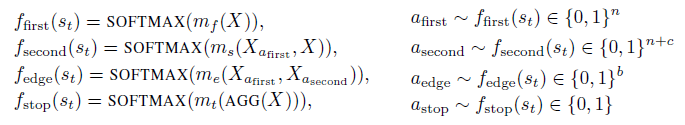

In [4]:
Image(filename = '../img/RL_action.png')

### 5. Policy Gradient Training
Proximal Policy Optimization(PPO)방법을 강화학습을 학습시키는 방법으로 채용하였다. Objective function은 아래와 같이 표현된다.
$$max L^{CLIP}(\theta) = \mathbb E_t [min(r_t(\theta)\hat{A_t}, clip(r_t(\theta), 1-\epsilon, 1+\epsilon)\hat{A_t}], r_t(\theta) = \frac{\pi_\theta(a_t|c_t)}{\pi_{\theta_{old}}(a_t|c_t)}$$
$\hat {A_t}$는 advantage function으로, value function $V_w(\cdot)$로 학습된 것이다. GCPN에서 $V_w(\cdot)$은 graph embedding을 4번에서 나온 것처럼 엮어주는 역할을 한다.  
Policy를 사전에 미리 학습시킨 후 적용하는 것은 좋은 결과를 얻을 수 있게 해준다. GCPN의 policy를 미리 학습 시키기 위해서 실제 분자를 사용하는데 ZINC에서 랜덤하게 $G$라는 분자를 선택하여 state $s_t$로 $G'$이라는 $G$의 subgraph를 고른 후 임의의 action $a_t$를 통해 $G$를 만들어지게 한다. 그렇게 하여 학습된 policy를 GCPN에 적용시킨다. 

## Experiments
총 세 가지의 목표가 있다.
1. Property Optimization: 특정 분자 성질이 optimized된 분자를 만들어내는 것
2. Property Targeting: 특정 분자 성질이 목표 점수에 가까운 분자를 만들어내는 것
3. Constrained Property Optimization: 1과 2를 만족하며 특정 subgraph를 포함하는 분자를 만들어내는 것  

실험은 25만개의 ZINC 데이터셋으로 진행되었고, rdkit을 사용하여 OpenAI Gym environment로 environment를 구축하였다. 한 분자의 최대 원자 개수는 38개, 9개의 원자 종류, 3개의 결합 종류(kekulized form이기 때문)로 설정하였다. 보상(reward)의 경우 화학에서 분자의 생성에 얼마나 중요한지에 따라 선형적으로 값을 매겼다. 모든 보상을 합하였을 때 최종적인 화학 성질 보상은 [-4, 4], 최종적인 화학 필터 보상은 [-2, 2], 최종적인 adversarial 보상은 [-1, 1], 중도 adversarial 보상은 [-1, 1], 중도 intermediate 보상은 [-1, 1]의 범위를 가졌다.  
Policy network를 구성하는 GCPN은 3개의 64차원의 layer를 가지고 있고, layer 다음에는 batch normalization이 학습에 적용되었다. 같은 구조의 다른 GCPN이 adversarial net을 학습시키는데 적용되었다. 강화 학습에 PPO 알고리즘을 적용하였는데 hyperparameter tuning을 하면서 큰 변화가 관찰되지 않았기 때문에 기본 hyperparameter를 사용하였고 learning rate는 0.001이었다. Pretraining objective는 learning rate 0.00025로 학습되었고 학습된 objective를 사용하면 더 빨리 결과에 수렴하고 더 나은 결과가 나온다는 것을 보았다.  
또한 결과들을 state-of-the-art baseline과 비교하였다. Junction Tree VAE는 그래프 표현과 VAE를 합친 것이고, ORGAN은 강화학습과 SMILES를 사용한 모델들인데 이들과 비교하기 위해 같은 objective function을 적용하고 같은 기기들로 실험하였다. 실험 결과도 좋았지만, 실험 시간도 다른 두 모델은 24시간 정도 걸렸지만 GCPN은 8시간이 걸렸다.

## Results
### 1. Property Optimization
이 문제에 대해서는 penalized logP와 QED 점수를 측정하였다. Penalized logP는 logP와 함께 고리의 크기나 합성 가능성을 같이 측정한 값이며 값이 제한되어 있지 않고, QED는 0과 1 사이의 값을 가진다. 아래의 표는 각 모델에서 가장 좋은 세 가지 property score와 화학적 가능성을 충분히 만족하는지 보여준다. GCPN은 JT-VAE에 비해 61%의 향상, ORGAN에 비해 무려 184%의 향상을 보여준다.  
더 자세하게 말하자면, ORGAN과 비교했을 때는 같은 강화 학습이라는 방법을 사용하였지만 GCPN에서 그래프 표현을 사용하였기에 훨씬 더 높은 validity를 볼 수 있었고, 값은 100%였다. JT-VAE와 비교하였을 땐 같은 그래프 표현을 사용하였지만 강화 학습 방법을 사용하여 VAE보다 더 optimize가 잘 되는 것을 볼 수 있었다.
부자연스럽거나 존재할 수 없는 분자들은 대부분 prior knowledge가 설정되지 않은 것이고 이것을 GCPN 모델에서는 adversarial training과 expert pretraining을 통해 실제 분자의 구조와 성질들을 restriction으로 제공해주어 나타날 수 없게 하였다. 하지만 이렇게 만들어진 분자들의 경우 empirical한 방법으로 만들어진 분자들에 비해 property score가 낮게 나오긴 하였다.

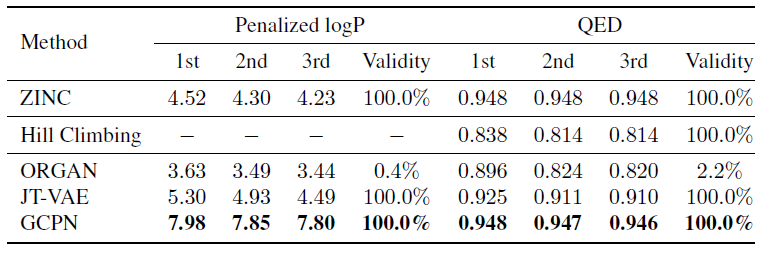

In [5]:
Image(filename = '../img/RL_table1.png')

### 2. Property Targeting
목표로 하는 성질인 분자량(MW), logP의 범위에 들어가는 분자의 비율과 다양성을 아래의 표에서 볼 수 있다. 다양성은 분자들의 Morgan fingerprints 사이의 평균적인 Tanimoto distance로 표현되었다. 강화학습의 보상은 만들어진 분자들의 property score와 range center 사이의 L1 distance로 실험을 진행하였다. 학습 난이도를 높이기 위해 논문에서는 아래의 표에 나와있는 것처럼 ZINC에서는 적은 수의 분자들이 포함된 성질들의 범위를 목표로 설정하였다.  
GCPN은 다른 모델들과 비교하여 목표 범위 내의 유의미한 높은 성공률을 보였다. 또한, 높은 다양성으로 분자들을 만들 수 있었고 이는 요구 성질들을 모두 만족하는 분자들을 만들 수 있는 일반적인 stochastic한 policy를 학습하였다는 것을 뜻한다.

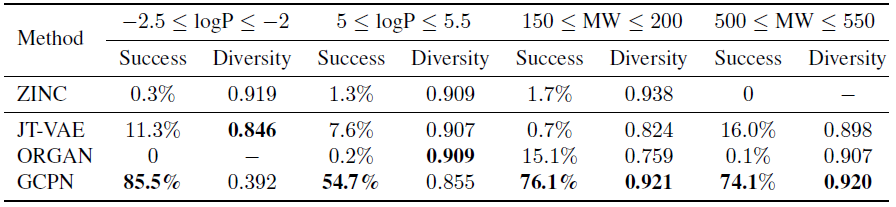

In [6]:
Image(filename = '../img/RL_table2.png')

### 3. Constrained Property Optimization
이 부분에서는 800개의 낮은 penalized logP 값을 가지는 ZINC 분자들 중 하나로부터 목표로 하는 penalized logP와 비슷한 값을 가지는 분자를 생성하였다. JT-VAE 모델은 생성된 분자가 특정 구조를 포함하도록 만들어내지 못하였다. 원래 분자와 변형된 분자 사이의 유사도($sim(G, G')$)가 특정 기준 $\delta$를 넘길 때 $\delta$에 따라 improvement, similarity, success rate를 측정하였다.  
논문에서는 고정된 구조의 GCPN을 초기 상태가 랜덤하게 설정된 800개의 ZINC 분자 중 하나로 학습시켰고 이후 property optimization과 같은 학습 방법을 적용하였다. GCPN은 JT-VAE를 평균 184%의 압도적인 비율로 높은 penalized logP 향상을 보여주었고 지속적으로 높은 logP 점수를 가진 분자들을 발견하였다. 또한, JT-VAE는 optimize할 때 분자마다 opimization step을 거치지만, GCPN은 policy를 한 번 학습시킨 것으로 모든 분자에 적용할 수 있다는 장점이 있다.

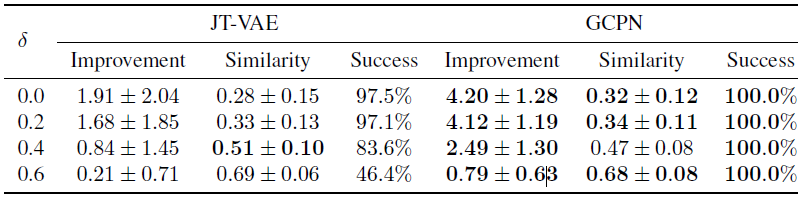

In [7]:
Image(filename = '../img/RL_table3.png')

## Conclusion
논문에서는 adversarial net과 결합된, 그래프 표현법을 사용하는 Graph Convolutional Policy Network라는 모델을 소개하였다. 이 모델은 특정 목표를 만족하는 새로운 분자를 다양한 제한 조건으로부터 만들 수 있고, 100% validity를 유지하며 새로이 분자를 만들어내는 task를 수행하는 다른 state-of-the-art 모델들보다 좋은 결과를 낸다.